# Pump It Up Challenge
## Tarea Machine Learning - Máster en Data Science, Big Data & Business Intelligence
### Fabio Ovidio Bianchini Cano


# <span style="color:orange">Procesamiento de datos</span>

Empezamos el procesamiento de datos juntando el dataset train y test incluyendo los labels.
Como la mayoría de valores perdidos son representados con 0, los vamos a sustituir.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from custom_functions import describe_numerical, describe_categorical, distribution_checker
# from dirty_cat import SimilarityEncoder
from rapidfuzz import fuzz
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train-values.csv", parse_dates = ["date_recorded"], na_values = [0, '0'])
labels = pd.read_csv("train-labels.csv")
test = pd.read_csv("test-values.csv", parse_dates = ["date_recorded"], na_values = [0, '0'])
train= pd.merge(labels , train, on='id')
data = pd.concat([train, test])
data.shape

(74249, 41)

## Valores perdidos

In [3]:
missing = round((data.isna().sum()) / len(data) * 100, 1)
missing = missing.sort_values(ascending = False)
missing.head(15)

num_private          98.7
amount_tsh           70.1
scheme_name          48.6
population           36.1
construction_year    35.0
gps_height           34.5
status_group         20.0
installer             7.4
funder                7.4
scheme_management     6.5
public_meeting        5.6
permit                5.1
longitude             3.1
subvillage            0.6
payment_type          0.0
dtype: float64

Obviando los valores NaN de status_group, hay 13 variables con valores nulos. No se imputarán valores en los que tengan más de la mitad de valores nulos.

### Longitud (3.1%)

Utilizaremos las variables region, lga, ward y subvillage para rellenar los valores perdidos de la longitud.

In [4]:
region = data.groupby(['region', 'lga', 'ward', 'subvillage'])['id'].sum().reset_index()
region.head(10)

,region,lga,ward,subvillage,id
0,Arusha,Arusha Rural,Bangata,Engikaleti,843711
1,Arusha,Arusha Rural,Bangata,Gwasei,69607
2,Arusha,Arusha Rural,Bangata,Kwaniche,142313
3,Arusha,Arusha Rural,Bangata,Lobolosi,51080
4,Arusha,Arusha Rural,Bangata,Melenyi,63946
5,Arusha,Arusha Rural,Bangata,Ndukenyi,73715
6,Arusha,Arusha Rural,Bangata,Ngwasei,109834
7,Arusha,Arusha Rural,Bangata,Sanganani,201984
8,Arusha,Arusha Rural,Bangata,Sangananu,20484
9,Arusha,Arusha Rural,Bwawani,Buluga,34309


Como ya hemos visto, esa es la jerarquía de las variables geográficas. 

Vamos a imputar por la media de la longitud en la que se presente la bomba.
Si conocemos la subvillage lo haremos por ésta, si no, lo haremos por el ward, y si no, la siguiente y así sucesivamente.

In [5]:
# Media de longitud en subvillage
means_longitude_subvillage = data.groupby(['region', 'lga', 'ward', 'subvillage'])['longitude'].mean().reset_index()
means_longitude_subvillage = means_longitude_subvillage.rename(columns={"longitude": "longitude_imputed_subvillage"})
display(means_longitude_subvillage.head())

# Ward
means_longitude_ward = data.groupby(['region', 'lga', 'ward',])['longitude'].mean().reset_index()
means_longitude_ward = means_longitude_ward.rename(columns={"longitude": "longitude_imputed_ward"})
display(means_longitude_ward.head())

# LGA
means_longitude_lga = data.groupby(['region', 'lga'])['longitude'].mean().reset_index()
means_longitude_lga = means_longitude_lga .rename(columns={"longitude": "longitude_imputed_lga"})
display(means_longitude_lga.head())

# Region
means_longitude_region = data.groupby(['region'])['longitude'].mean().reset_index()
means_longitude_region = means_longitude_region.rename(columns={"longitude": "longitude_imputed_region"})
means_longitude_region.head()

,region,lga,ward,subvillage,longitude_imputed_subvillage
0,Arusha,Arusha Rural,Bangata,Engikaleti,36.740347
1,Arusha,Arusha Rural,Bangata,Gwasei,36.750458
2,Arusha,Arusha Rural,Bangata,Kwaniche,36.749773
3,Arusha,Arusha Rural,Bangata,Lobolosi,36.742997
4,Arusha,Arusha Rural,Bangata,Melenyi,36.746082


,region,lga,ward,longitude_imputed_ward
0,Arusha,Arusha Rural,Bangata,36.743789
1,Arusha,Arusha Rural,Bwawani,36.813002
2,Arusha,Arusha Rural,Ilkiding'a,36.686382
3,Arusha,Arusha Rural,Kimnyaki,36.650511
4,Arusha,Arusha Rural,Kiranyi,36.660728


,region,lga,longitude_imputed_lga
0,Arusha,Arusha Rural,36.700645
1,Arusha,Arusha Urban,36.686083
2,Arusha,Karatu,35.661994
3,Arusha,Longido,36.698130
4,Arusha,Meru,36.882775


,region,longitude_imputed_region
0,Arusha,36.554067
1,Dar es Salaam,39.212935
2,Dodoma,36.041964
3,Iringa,34.895921
4,Kagera,31.233092


In [6]:
# Mergeamos las columnas que hemos creado al dataframe original
data = data.merge(means_longitude_subvillage, how = 'left', on = ['region', 'lga', 'ward', 'subvillage'])
data = data.merge(means_longitude_ward, how = 'left', on = ['region', 'lga', 'ward'])
data = data.merge(means_longitude_lga, how = 'left', on = ['region', 'lga'])
data = data.merge(means_longitude_region, how = 'left', on = ['region'])

#select the right longitude level based on the availability of information
data['imputed_longitude'] = np.where(data['longitude'].isna(), data['longitude_imputed_subvillage'], data['longitude']) #if longitude is missing, impute it by the mean of the subvillage
data['imputed_longitude'] = np.where(data['imputed_longitude'].isna(), data['longitude_imputed_ward'], data['imputed_longitude']) #if subvillage mean is missing, impute it by the ward
data['imputed_longitude'] = np.where(data['imputed_longitude'].isna(), data['longitude_imputed_lga'], data['imputed_longitude'])
data['imputed_longitude'] = np.where(data['imputed_longitude'].isna(), data['longitude_imputed_region'], data['imputed_longitude'])

#drop redundant columns
data= data.drop(['longitude_imputed_subvillage','longitude_imputed_ward' , 'longitude_imputed_lga' , 'longitude_imputed_region', 'longitude'], axis=1)
round((data["imputed_longitude"].isna().sum()) / len(data) * 100, 1)

0.0

### Public meeting (5.6%)

Public meeting tiene un 91% de valores verdaderos, imputaremos por la moda.

In [7]:
data['public_meeting'] = data['public_meeting'].fillna(data['public_meeting'].mode()[0])
round((data["public_meeting"].isna().sum()) / len(data) * 100, 1)

0.0

### Permit (5.1%)

Predijimos en el estudio de variables que permit probablemente no fuese una variable importante dado a que no cambia mucho la funcionalidad de la bomba si se tiene permiso o no. 

Imputaremos en función de la moda de nuevo.

In [8]:
data['permit'] = data['permit'].fillna(data['permit'].mode()[0])
round((data["permit"].isna().sum()) / len(data) * 100, 1)

0.0

### Scheme management (6.5%)

Teniendo en cuenta que management_group, management y scheme_management están muy relacionados podemos utilizar la otra variable para imputar por la moda.

In [9]:
check = data.groupby(['management_group', 'management', 'scheme_management'])['id'].count().reset_index()
check = check.sort_values(["management", "id"], ascending = [True, False])
check.head(10)

,management_group,management,scheme_management,id
0,commercial,company,Company,848
5,commercial,company,WUG,4
1,commercial,company,Private operator,2
3,commercial,company,VWC,2
2,commercial,company,Trust,1
4,commercial,company,WUA,1
31,other,other,Other,690
33,other,other,VWC,57
37,other,other,Water authority,54
36,other,other,Water Board,26


In [10]:
scheme_mode = data.groupby(['management'])['scheme_management'].agg(pd.Series.mode).reset_index()
scheme_mode = scheme_mode.rename(columns = {"scheme_management": "imputed_scheme__management"})
scheme_mode 

,management,imputed_scheme__management
0,company,Company
1,other,Other
2,other - school,SWC
3,parastatal,Parastatal
4,private operator,Private operator
5,trust,Trust
6,unknown,VWC
7,vwc,VWC
8,water authority,Water authority
9,water board,Water Board


In [11]:
# Juntamos el nuevo dataframe con el nuestro y procuramos rellenar los NaN con los valores obtenidos
data = data.merge(scheme_mode, how = 'left', on = ['management'])
data['imputed_scheme_management'] = np.where(data['scheme_management'].isna(), data['imputed_scheme__management'], data['scheme_management'])

# Eliminamos las columnas sobrantes
data = data.drop(['scheme_management', 'imputed_scheme__management'],axis=1)
round((data["imputed_scheme_management"].isna().sum()) / len(data) * 100, 1)

0.0

### Installer (7.4%)

Installer es una variable categórica con más de 2000 valores únicos. Vamos primero a procesarlos para tratarlos correctamente.


In [12]:
data['installer'] = data['installer'].str.lower()

installer = data.groupby('installer')['id'].count().reset_index()
installer = installer.sort_values('id', ascending = False)
installer.head(10)

,installer,id
433,dwe,21756
570,government,2367
650,hesawa,1768
1620,rwe,1498
295,commu,1354
353,danida,1306
406,district council,1181
879,kkkt,1135
230,central government,933
1847,tcrs,887


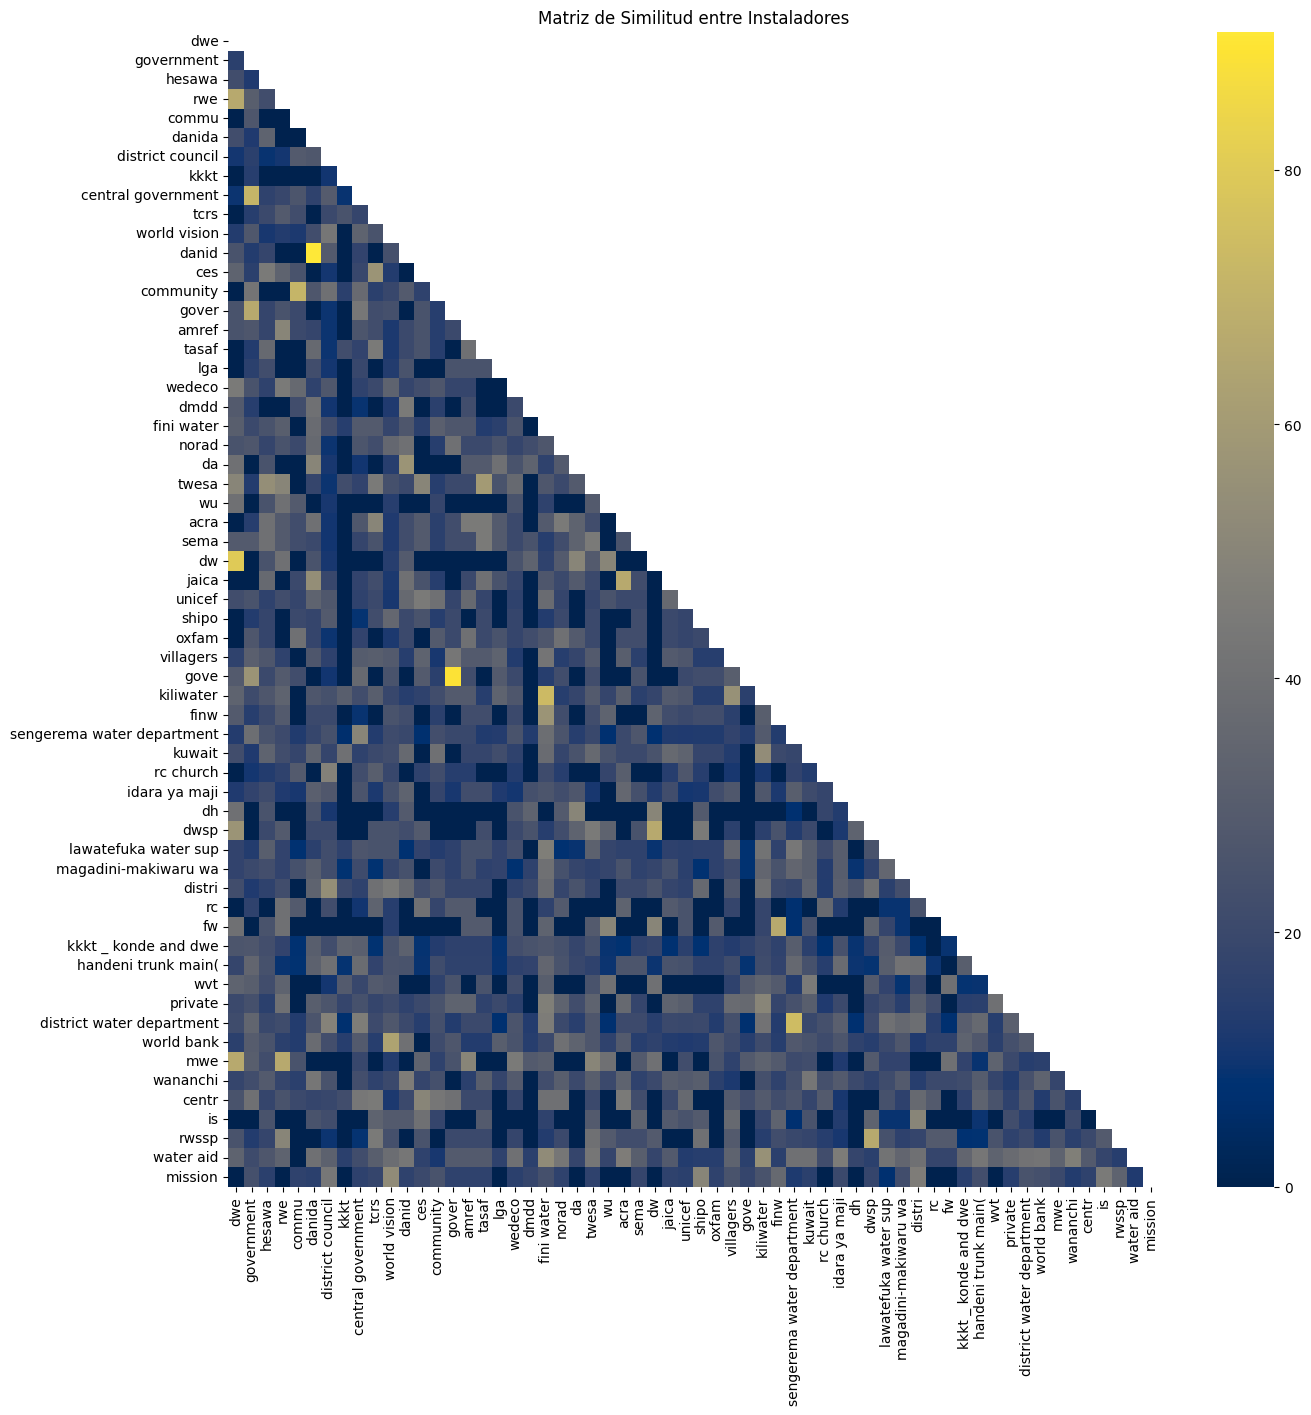

In [13]:
# Matriz de correlación de los instaladores más comunes
top_installers = installer.nlargest(60, 'id')['installer'].unique()
n = top_installers.size
similarity_matrix = np.zeros((n, n))

for i in range(n):
    similarity_matrix[i, :i + 1] = [fuzz.ratio(top_installers[i], top_installers[j]) for j in range(i + 1)]

mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

plt.figure(figsize=(15, 15))
sns.heatmap(similarity_matrix, mask=mask, xticklabels=top_installers, yticklabels=top_installers, cmap='cividis', annot=False)
plt.title('Matriz de Similitud entre Instaladores')
plt.show()

Vamos a juntar algunas variables que parecen demasiado similares tanto en valores de la variable como en el propio nombre de la variable.
Puede que se traten de erratas.


In [14]:
data['installer'] = np.where( data['installer']=='gove', 'gover', data['installer'] )
data['installer'] = np.where( data['installer']=='community', 'commu', data['installer'] )
data['installer'] = np.where( data['installer']=='danid', 'danida', data['installer'] )

installer = data.groupby('installer')['id'].count().reset_index()
installer = installer.sort_values('id', ascending = False)
installer.head(10)

,installer,id
431,dwe,21756
567,government,2367
351,danida,2092
295,commu,2044
647,hesawa,1768
1617,rwe,1498
404,district council,1181
876,kkkt,1135
230,central government,933
562,gover,929


No hay forma fácil de lidiar con la alta cardinalidad a partir de este momento, tendremos que hacer una criba. 

Después de un poco de juego con los valores, he llegado a la conclusión de que vale la pena quedarse con aproximadamente el top 100 de los instaladores. 

In [15]:
top_installers = installer.nlargest(100, 'id')['installer'].unique()

# Los que no estén en el top 100 los cambiamos por "other"
data['installer'] = np.where(data['installer'].isin(top_installers), data['installer'], 'other')

In [16]:
round((data["installer"].isna().sum()) / len(data) * 100, 1)

0.0

### Funder (7.4%)

In [17]:
# Ponemos todos los valores en minúscula, igual que con los installers
data['funder'] = data['funder'].str.lower()

funder = data.groupby('funder')['id'].count().reset_index()
funder = funder.sort_values('id', ascending = False)
funder.head(10)

,funder,id
506,government of tanzania,11299
292,danida,3907
572,hesawa,2782
1597,rwssp,1703
2104,world bank,1701
807,kkkt,1623
2106,world vision,1562
1959,unicef,1324
1839,tasaf,1135
326,dhv,1065


De nuevo, con la cardinalidad astronómica que tiene funder, haremos una criba del top 100, que sigue siendo aproximadamente el valor ideal.

In [18]:
top_funders = funder.nlargest(100, 'id')['funder'].unique()

# Los que no estén en el top 100 los cambiamos por "other"
data['funder'] = np.where(data['funder'].isin(top_funders), data['funder'], 'other')

### Construction Year (35%)

Imputaremos construction_year por la media de sus valores.

In [19]:
#We can see that the mean construction year by extraction type group gives much more detailed information
mean_construction = data['construction_year'].mean()
mean_construction 

1996.8709430210642

In [20]:
data['construction_year'] = data['construction_year'].fillna(mean_construction)
round((data["construction_year"].isna().sum()) / len(data) * 100, 1)

0.0

### GPS Height (34.5%)

Como ya hemos comentado, los valores a 0 o por debajo de 0 no tienen sentido puesto que Tanzania no está por debajo del nivel del mar.

Imputaremos los valores nulos por la media de las regiones, utilizando la misma técnica que con la longitud, utilizando las variables region, lga, ward y subvillage respectivamente. Aunque ahora incluiremos basin, ya que considero que puede tener algo que ver con la altura de las bombas.

In [21]:
# Media por subvillage
means_altitude_subvillage = data.groupby(['region', 'lga', 'ward', 'subvillage'])['gps_height'].mean().reset_index()
means_altitude_subvillage = means_altitude_subvillage.rename(columns={"gps_height": "gps_height_imputed_subvillage"})

# Media por ward
means_altitude_ward = data.groupby(['region', 'lga', 'ward',])['gps_height'].mean().reset_index()
means_altitude_ward = means_altitude_ward.rename(columns={"gps_height": "gps_height_imputed_ward"})

# Media por lga
means_altitude_lga = data.groupby(['region', 'lga'])['gps_height'].mean().reset_index()
means_altitude_lga = means_altitude_lga .rename(columns={"gps_height": "gps_height_imputed_lga"})

# Media por region
means_altitude_region = data.groupby(['region'])['gps_height'].mean().reset_index()
means_altitude_region = means_altitude_region.rename(columns={"gps_height": "gps_height_imputed_region"})

# Media por basin
means_altitude_basin = data.groupby(['basin'])['gps_height'].mean().reset_index()
means_altitude_basin = means_altitude_basin.rename(columns={"gps_height": "gps_height_imputed_basin"})

# Añadimos todas las columnas nuevas al dataframe 
data = data.merge(means_altitude_subvillage, how = 'left', on = ['region', 'lga', 'ward', 'subvillage'])
data = data.merge(means_altitude_ward, how = 'left', on = ['region', 'lga', 'ward'])
data = data.merge(means_altitude_lga, how = 'left', on = ['region', 'lga'])
data = data.merge(means_altitude_region, how = 'left', on = ['region'])
data = data.merge(means_altitude_basin, how = 'left', on = ['basin'])

# Juntamos todas las columnas nuevas en una sola
data['imputed_gps_height'] = np.where(data['gps_height'].isna(), data['gps_height_imputed_subvillage'], data['gps_height']) #if longitude is missing, impute it by the mean of the subvillage
data['imputed_gps_height'] = np.where(data['imputed_gps_height'].isna(), data['gps_height_imputed_ward'], data['imputed_gps_height']) #if subvillage mean is missing, impute it by the ward
data['imputed_gps_height'] = np.where(data['imputed_gps_height'].isna(), data['gps_height_imputed_lga'], data['imputed_gps_height'])
data['imputed_gps_height'] = np.where(data['imputed_gps_height'].isna(), data['gps_height_imputed_region'], data['imputed_gps_height'])
data['imputed_gps_height'] = np.where(data['imputed_gps_height'].isna(), data['gps_height_imputed_basin'], data['imputed_gps_height'])

# Eliminamos las columnas temporales que hemos utilizado
data = data.drop(['gps_height_imputed_subvillage','gps_height_imputed_ward' , 'gps_height_imputed_lga' , 'gps_height_imputed_region', 'gps_height', 'gps_height_imputed_basin'], axis=1)

In [22]:
round((data["imputed_gps_height"].isna().sum()) / len(data) * 100, 1)

0.0

### Population (36.1%)

Utilizaremos exactamente la misma estrategia que para la altura GPS, puesto que considero que es una técnica que funciona bien en ambos casos.

In [23]:
# Media por subvillage
means_population_subvillage = data.groupby(['region', 'lga', 'ward', 'subvillage'])['population'].mean().reset_index()
means_population_subvillage = means_population_subvillage.rename(columns={"population": "population_imputed_subvillage"})

# Media por ward
means_population_ward = data.groupby(['region', 'lga', 'ward',])['population'].mean().reset_index()
means_population_ward = means_population_ward.rename(columns={"population": "population_imputed_ward"})

# Media por lga
means_population_lga = data.groupby(['region', 'lga'])['population'].mean().reset_index()
means_population_lga = means_population_lga.rename(columns={"population": "population_imputed_lga"})

# Media por region
means_population_region = data.groupby(['region'])['population'].mean().reset_index()
means_population_region = means_population_region.rename(columns={"population": "population_imputed_region"})

# Media por basin
means_population_basin = data.groupby(['basin'])['population'].mean().reset_index()
means_population_basin = means_population_basin.rename(columns={"population": "population_imputed_basin"})

# Añadimos todas las columnas nuevas al dataframe 
data = data.merge(means_population_subvillage, how = 'left', on = ['region', 'lga', 'ward', 'subvillage'])
data = data.merge(means_population_ward, how = 'left', on = ['region', 'lga', 'ward'])
data = data.merge(means_population_lga, how = 'left', on = ['region', 'lga'])
data = data.merge(means_population_region, how = 'left', on = ['region'])
data = data.merge(means_population_basin, how = 'left', on = ['basin'])

# Juntamos todas las columnas nuevas en una sola
data['imputed_population'] = np.where(data['population'].isna(), data['population_imputed_subvillage'], data['population'])
data['imputed_population'] = np.where(data['imputed_population'].isna(), data['population_imputed_ward'], data['imputed_population'])
data['imputed_population'] = np.where(data['imputed_population'].isna(), data['population_imputed_lga'], data['imputed_population'])
data['imputed_population'] = np.where(data['imputed_population'].isna(), data['population_imputed_region'], data['imputed_population'])
data['imputed_population'] = np.where(data['imputed_population'].isna(), data['population_imputed_basin'], data['imputed_population'])

# Eliminamos las columnas temporales que hemos utilizado
data = data.drop(['population_imputed_subvillage','population_imputed_ward' , 'population_imputed_lga' , 'population_imputed_region', 'population', 'population_imputed_basin'], axis=1)

In [24]:
round((data["imputed_population"].isna().sum()) / len(data) * 100, 1)

0.0

### Columnas insalvables 

Hay columnas dentro del dataset que, lamentablemente, tienen tantos valores nulos que no podemos imputarlas de ninguna manera lógica sin arruinar la información que nos podrían aportar. Vamos a eliminarlas por completo de nuestro dataset.

In [25]:
data = data.drop(columns=["num_private", "scheme_name"])

## Tipos de datos

A lo largo del proceso de imputación hay muchas columnas que han cambiado erróneamente de tipo. Corrijamos eso.

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74249 entries, 0 to 74248
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         74249 non-null  int64         
 1   status_group               59399 non-null  object        
 2   amount_tsh                 22201 non-null  float64       
 3   date_recorded              74249 non-null  datetime64[ns]
 4   funder                     74249 non-null  object        
 5   installer                  74249 non-null  object        
 6   latitude                   74249 non-null  float64       
 7   wpt_name                   74247 non-null  object        
 8   basin                      74249 non-null  object        
 9   subvillage                 73779 non-null  object        
 10  region                     74249 non-null  object        
 11  region_code                74249 non-null  int64         
 12  dist

In [27]:
# Booleano -> Entero
data['public_meeting'] = data['public_meeting'].replace({True: 1, False: 0})
data['permit'] = data['permit'].replace({True: 1, False: 0})


# Flotante -> Entero
data[['imputed_gps_height', 'construction_year', 'imputed_population']] = data[['imputed_gps_height', 'construction_year', 'imputed_population']].astype('int')

# * -> Categórica
data[['region_code', 'district_code']] = data[['region_code', 'district_code']].astype('str')

# Quitar decimal
data['district_code'] = data['district_code'].str.split(".").str[0]

Renombramos las columnas a las que habíamos cambiado el nombre temporalmente a su valor original.

In [28]:
data = data.rename(columns={"imputed_scheme_management": "scheme_management", "imputed_gps_height": "gps_height", 
                   'imputed_population': 'population', 'imputed_longitude': 'longitude'}, errors="raise")

<a name="preprocess" />

# <span style="color:HotPink">Ingeniería de atributos</span>

Por fin avanzamos de etapa, dejando atrás el preprocesamiento de datos. Ahora crearemos variables nuevas y modificaremos las antiguas para aportar más información o la misma de manera más estructurada.

In [29]:
processed_df = data.copy()

### Edad de la bomba

Vale la pena guardar en una variable cuántos años lleva construida la bomba.

In [30]:
processed_df['recorded_year'] = pd.DatetimeIndex(processed_df ['date_recorded']).year
processed_df['age'] = processed_df['recorded_year'] - processed_df['construction_year']
processed_df = processed_df.drop('recorded_year',axis=1)

### Amount tsh missing

Como ya hemos hablado en el estudio estadístico, las bombas que contienen valores en amount_tsh tienen una mayor probabilidad de ser funcionales, con respecto a las que no. Vamos a guardar la variable en vez de como valor flotante, como valor booleano.

In [31]:
processed_df['amount_tsh_missing'] = np.where(processed_df['amount_tsh'].isna(), 1, 0)
distribution_checker(processed_df, 'amount_tsh_missing')

,Num_bombas,Porcentaje_total_bombas,Porcentaje_funcional,Porcentaje_NO_funcional,Porcentaje_reparacion
amount_tsh_missing,,,,,
0,17761.0,29.9,70.7,22.2,7.1
1,41638.0,70.1,47.3,45.4,7.3


### Region District

Juntaremos las variables region y district_code. Es importante puesto que la segunda depende de la primera.

In [32]:
processed_df['region_district'] = processed_df['region']+ "-" + processed_df['district_code']
region_district = distribution_checker(processed_df,  'region_district')
region_district.head()

,Num_bombas,Porcentaje_total_bombas,Porcentaje_funcional,Porcentaje_NO_funcional,Porcentaje_reparacion
region_district,,,,,
Arusha-1,189.0,0.3,50.3,33.9,15.9
Arusha-2,1206.0,2.0,69.6,26.6,3.8
Arusha-3,109.0,0.2,71.6,20.2,8.3
Arusha-30,326.0,0.5,96.9,2.8,0.3
Arusha-5,201.0,0.3,54.2,31.8,13.9


### Longitud y latitud

Simplificamos las variables longitud y latitud, al fin y al cabo no se necesita especificar tanto en la posición de la bomba en el mapa. Dos decimales será suficiente.

In [33]:
processed_df['longitude'] = round(processed_df['longitude'], 2)
processed_df['latitude'] = round(processed_df['latitude'],2)

### Variables de extracción

Tenemos que juntar las variables de extracción, analicémoslas de nuevo para ver cómo hacerlo

In [34]:
describe_categorical(processed_df[["extraction_type_class", "extraction_type_group", "extraction_type"]])

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
extraction_type_class,object,74249,7,0,0.0,gravity,33263,44.8
extraction_type_group,object,74249,13,0,0.0,gravity,33263,44.8
extraction_type,object,74249,18,0,0.0,gravity,33263,44.8


In [35]:
processed_df.groupby(['extraction_type_class', 'extraction_type_group', 'extraction_type'])['id'].count().reset_index()

,extraction_type_class,extraction_type_group,extraction_type,id
0,gravity,gravity,gravity,33263
1,handpump,afridev,afridev,2207
2,handpump,india mark ii,india mark ii,3029
3,handpump,india mark iii,india mark iii,135
4,handpump,nira/tanira,nira/tanira,10205
5,handpump,other handpump,other - mkulima/shinyanga,2
6,handpump,other handpump,other - play pump,101
7,handpump,other handpump,other - swn 81,284
8,handpump,other handpump,walimi,60
9,handpump,swn 80,swn 80,4588


Algunos valores de extraction_type no aportan tanta información nueva como para tenerlos como valores individuales. Esos valores de deberán juntarse entre sí.

In [36]:
# swn 80 y swn 81 se transforman en swn
# cemo + climax se transforman en other motorpump
# other-mkulima, other-play and walimi se transforman en other handpump

swn = ['other - swn 81', 'swn80']
processed_df['extraction_type'] = np.where(processed_df['extraction_type'].isin(swn), 'swn', processed_df['extraction_type'])

other_handpump = ['other - mkulima/shinyanga', 'other - play pump', 'other - walimi']
processed_df['extraction_type'] = np.where(processed_df['extraction_type'].isin(other_handpump), 'other handpump',  processed_df['extraction_type'])

other_motorpump = ['cemo', 'climax']
processed_df['extraction_type'] = np.where(processed_df['extraction_type'].isin(other_motorpump), 'other motorpump',  processed_df['extraction_type'])

### Valores de fuente de origen (sources)

In [37]:
processed_df.groupby(['source_class', 'source_type','source' ])['id'].count().reset_index()

,source_class,source_type,source,id
0,groundwater,borehole,hand dtw,1108
1,groundwater,borehole,machine dbh,13822
2,groundwater,shallow well,shallow well,21139
3,groundwater,spring,spring,21216
4,surface,dam,dam,840
5,surface,rainwater harvesting,rainwater harvesting,2863
6,surface,river/lake,lake,950
7,surface,river/lake,river,11964
8,unknown,other,other,261
9,unknown,other,unknown,86


Los valores raros los juntaremos entre sí (unknown y other separados no aportan nada de información).

In [38]:
other = ['other',  'unknown']
processed_df['source'] = np.where(processed_df['source']=='unknown', 'other', processed_df['source'])

## Eliminación de variables

Podemos eliminar las redundantes o que no aportan información importante.

Recordemos que esto es el resultado de haber sacado conclusiones del estudio estadístico de las variables en la primera parte del ejercicio, de haber imputado los valores nulos, de haber reducido las variables categóricas en cardinalidades más manejables y de haber creado variables nuevas con las que trabajar.

In [39]:
processed_df = processed_df.drop(['amount_tsh', 'date_recorded', 'wpt_name', 'subvillage', 'region',  'district_code', 'lga', 'ward', 'recorded_by', 'extraction_type_group', 'management', 'management_group', 'payment', 'quality_group', 'quantity_group', 'source_class', 'source_type', 'waterpoint_type_group', 'construction_year'], axis=1)
processed_df.head()

,id,status_group,funder,installer,latitude,basin,region_code,public_meeting,permit,extraction_type,...,quantity,source,waterpoint_type,longitude,scheme_management,gps_height,population,age,amount_tsh_missing,region_district
0,69572,functional,roman,roman,-9.86,Lake Nyasa,11,1,0,gravity,...,enough,spring,communal standpipe,34.94,VWC,1390,109,12,0,Iringa-5
1,8776,functional,other,other,-2.15,Lake Victoria,20,1,1,gravity,...,insufficient,rainwater harvesting,communal standpipe,34.70,Other,1399,280,3,1,Mara-2
2,34310,functional,other,world vision,-3.82,Pangani,21,1,1,gravity,...,enough,dam,communal standpipe multiple,37.46,VWC,686,250,4,0,Manyara-4
3,67743,non functional,unicef,unicef,-11.16,Ruvuma / Southern Coast,90,1,1,submersible,...,dry,machine dbh,communal standpipe multiple,38.49,VWC,263,58,27,1,Mtwara-63
4,19728,functional,other,artisan,-1.83,Lake Victoria,18,1,1,gravity,...,seasonal,rainwater harvesting,communal standpipe,31.13,Other,1328,532,15,1,Kagera-1


## Codificación (Encoding)

Pasamos ahora a codificar las variables categóricas para poder tratarlas como numéricas.

In [40]:
# Separamos el dataset completo en train y test, como al principio.
train_set = processed_df [processed_df ["id"].isin(train["id"])]
test_set = processed_df [processed_df ["id"].isin(test["id"])]

In [41]:
X = train_set.drop(['id', 'status_group'], axis=1)
y = train_set['status_group']

In [42]:
# 13 variables categóricas que codificar
categorical_cols = [cname for cname in X .columns if X [cname].dtype == "object"]
categorical_cols

['funder',
 'installer',
 'basin',
 'region_code',
 'extraction_type',
 'extraction_type_class',
 'payment_type',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type',
 'scheme_management',
 'region_district']

In [43]:
# Codificamos con LabelEncoder
for col in categorical_cols:
  le = LabelEncoder()
  train_set[col] = le.fit_transform(train_set[col])
  test_set[col] = le.transform(test_set[col])

Juntamos de nuevo train y test

In [44]:
processed_df = pd.concat([train_set, test_set], ignore_index = True)
processed_df

,id,status_group,funder,installer,latitude,basin,region_code,public_meeting,permit,extraction_type,...,quantity,source,waterpoint_type,longitude,scheme_management,gps_height,population,age,amount_tsh_missing,region_district
0,69572,functional,71,72,-9.86,1,2,1,0,1,...,1,8,1,34.94,6,1390,109,12,0,20
1,8776,functional,62,65,-2.15,4,12,1,1,1,...,2,5,1,34.70,1,1399,280,3,1,55
2,34310,functional,62,98,-3.82,5,13,1,1,1,...,1,0,2,37.46,6,686,250,4,0,52
3,67743,non functional,89,83,-11.16,7,25,1,1,11,...,0,3,2,38.49,6,263,58,27,1,76
4,19728,functional,62,5,-1.83,4,9,1,1,1,...,3,5,1,31.13,1,1328,532,15,1,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74244,39307,NaN,13,14,-6.58,8,19,1,1,5,...,1,6,1,38.85,6,34,20,23,1,85
74245,18990,NaN,62,65,-5.35,5,16,1,0,6,...,2,7,4,37.45,6,669,2960,17,0,130
74246,28749,NaN,62,65,-4.59,0,4,1,1,1,...,2,0,1,34.74,6,1476,200,3,1,115
74247,33492,NaN,25,25,-10.58,1,1,1,1,1,...,2,6,1,35.43,6,998,150,4,1,101


In [45]:
processed_df.to_csv("processed_df.csv", index=False)